# Detecting bullying Tweets with PyTorch LSTM + Attention 

This project is about the analysis of tweets about cyberbullying, with the goal of performing a Sentiment Analysis using LSTM w/ Attention on PyTorch to predict if a tweet is about cyberbullying or not. <br>
In particular, bullying tweets are divided in 4 categories: religion, age, race and gender.<br>
The project is divided in the following sections:

- Data Import
- Text cleaning with custom defined functions
- Data preparation for LSTM RNN: Tokenization
- PyTorch LSTM RNN Classifier w/ Attention
- Results summary


In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv


## Custom functions definition:

In [2]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

In [3]:
pip install langdetect

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install contractions

Note: you may need to restart the kernel to use updated packages.


## Import libraries

In [5]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

import time

# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

<Figure size 432x288 with 0 Axes>

## Data Import

In [6]:
df = pd.read_csv("/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv")

In [7]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


First we rename the columns using shorter words for easier reference.

In [9]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

### Are there duplicated tweets?

In [10]:
df.duplicated().sum()

36

There are some duplicated tweets, we will remove them.

In [11]:
df = df[~df.duplicated()]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47656 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       47656 non-null  object
 1   sentiment  47656 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


### Are the classes balanced?

In [13]:
df.sentiment.value_counts()

religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: sentiment, dtype: int64

The classes look balanced.

# Tweets text deep cleaning

Next, we will define custom functions to clean the texts of the tweets.

In [14]:
# Clean emojis from text
def strip_emoji(text):
    return emoji.get_emoji_regexp().sub("", text)

# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()
    
    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()
    
    return new_tweet

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [15]:
df['text_clean'] = [clean_tweet(tweet) for tweet in df['text']]

In [16]:
df.head()

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks head concerned another angry dude t...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account like is...


### Are there duplicate tweets after the cleaning?

In [17]:
print(f'There are around {int(df["text_clean"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 6254 duplicated tweets, we will remove them.


In [18]:
df.drop_duplicates("text_clean", inplace=True)

We removed the duplicated cleaned tweets. How is the class balance after the cleaning?

In [19]:
df.sentiment.value_counts()

religion               7916
age                    7813
ethnicity              7405
gender                 7276
not_cyberbullying      6074
other_cyberbullying    4918
Name: sentiment, dtype: int64

We can see that lots of tweets of the class "other_cyberbullying" have been removed. Since the class is very unbalanced compared to the other classes and looks too "generic", we decide to remove the tweets labeled belonging to this class.<br>
EDIT: by performing some tests, the f1 score for predicting the "other_cyberbullying" resulted to be around 60%, a value far lower compared to the othter f1 scores (around 95% using LSTM model). This supports the decision of removing this generic class.

In [20]:
df = df[df["sentiment"]!="other_cyberbullying"]

Then we also define a list of the classes names, which will be useful for the future plots.

In [21]:
sentiments = ["religion","age","ethnicity","gender","not bullying"]

# Tweets length analysis

Now we will define a new dataframe column containing the length of the cleaned tweets in terms of number of words.

In [22]:
df['text_len'] = [len(text.split()) for text in df.text_clean]

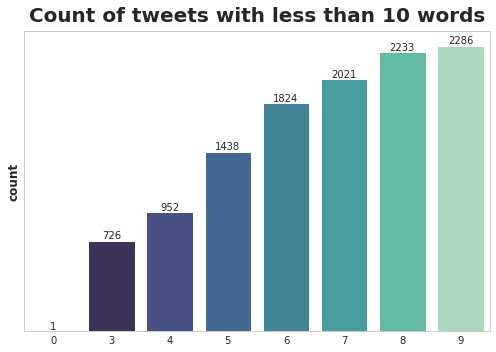

In [23]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

### What about long tweets?

In [24]:
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
44035,You so black and white trying to live like a n...,ethnicity,black white trying live like nigger pahahahaha...,173
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",ethnicity,fuck obama dumb as nigger bitch ltthis whore s...,151
1317,@EurekAlertAAAS: Researchers push to import to...,not_cyberbullying,researcher push import top antibullying progra...,138
33724,"... I don't feel guilty for killing him, I jus...",age,feel guilty killing feel guilty enjoyed tormen...,136
10922,don't make rape jokes!!! don't make gay jokes!...,gender,make rape joke make gay joke oh fat joke okay ...,121
...,...,...,...,...
573,@Popehat i can never tell anymore.,not_cyberbullying,never tell anymore,3
5232,@Mesha_nojas: @_Vontethekidd &#128079;&#128079...,not_cyberbullying,got hick lol,3
7153,That's unfair and fucked up #mkr,not_cyberbullying,unfair fucked mkr,3
630,People from my school are up here. Ew,not_cyberbullying,people school ew,3


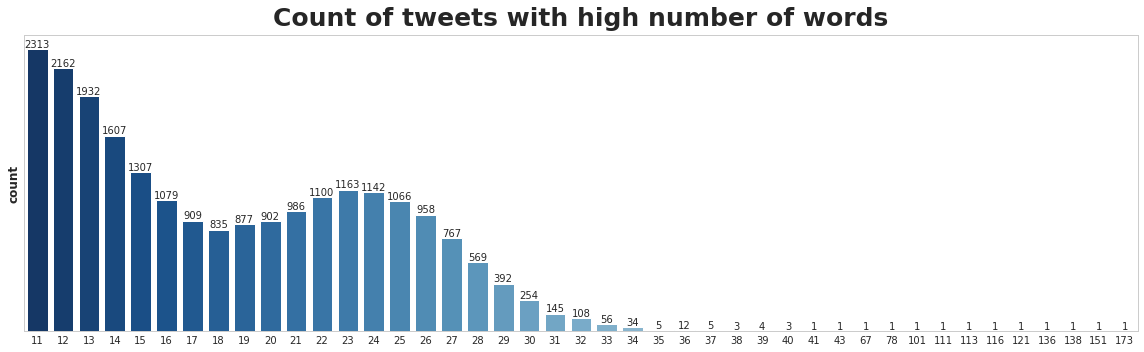

In [25]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

We also will remove tweets that are too long (with more than 100 words).

In [26]:
df = df[df['text_len'] < df['text_len'].quantile(0.995)]

Then we also get the length of the longest tweet since it will be useful later.

In [27]:
max_len = np.max(df['text_len'])
max_len 

31

In [28]:
df.sort_values(by=["text_len"], ascending=False)

,text,sentiment,text_clean,text_len
42342,U really gonna act like a lot of people didnt ...,ethnicity,really going act like lot people dumb shitman ...,31
47445,"White shall henceforth be called cracker, honk...",ethnicity,white shall henceforth called cracker honky gr...,31
18840,"At #UNGA Imran Khan explain below only. Jihad,...",religion,unga imran khan explain jihad war nuclear war ...,31
36608,Getting paid on both sides. Bill G literally d...,age,getting paid side bill literally dismantled af...,31
34994,"Over the next nine years, Parker grew to be ex...",age,next nine year parker grew extremely bright sc...,31
...,...,...,...,...
36133,Bully https://www.twitch.tv/jeffgamer55ryer @T...,age,bully old school,3
5903,@apache6645 thursday n friday confirmed,not_cyberbullying,thursday friday confirmed,3
5891,Starting To Get An Headache.,not_cyberbullying,starting get headache,3
1417,Gotta love this movie.......,not_cyberbullying,got love movie,3


## Sentiment column encoding

The target column will be encoded by ordinal encoding

In [29]:
df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

## Train - Test split

Now we need to split the dataset into a train and test sets.

In [30]:
X = df['text_clean']
y = df['sentiment']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

## Train - Validation split

Moreover, we will further split the training set to extract a validation set, which will be used to monior the accuracy and loss to avoid overfitting during the model training.

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [33]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5015],
       [   1, 4965],
       [   2, 4701],
       [   3, 4626],
       [   4, 3886]])

The classes are unbalanced, so it could be a good idea to oversample the training set such that all classes have the same count as the most populated one.

# Oversampling of training set

In [34]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment']);

In [35]:
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

In [36]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5015],
       [   1, 5015],
       [   2, 5015],
       [   3, 5015],
       [   4, 5015]])

# PyTorch LSTM RNN w/ Attention

In this section, we will define a custom Unidirectional and Bidirectional LSTM using PyTorch in order to perform the Sentiment Analysis on the tweets.

## Data preprocessing for LSTM

In [44]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [45]:
vocabulary, tokenized_column = Tokenize(df["text_clean"], max_len)

We can check how each tweet has been tokenized with an example:

In [46]:
df["text_clean"].iloc[0]

'word katandandre food crapilicious mkr'

This sentence is transformed to the vector:

In [47]:
tokenized_column[10]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,    11,  7699, 15536])

Moreover we can also check the TOP 20 most common words by extracting them from the vocabulary python dictionary we created with the tokenizer.

In [48]:
keys = []
values = []
for key, value in vocabulary[:20]:
    keys.append(key)
    values.append(value)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


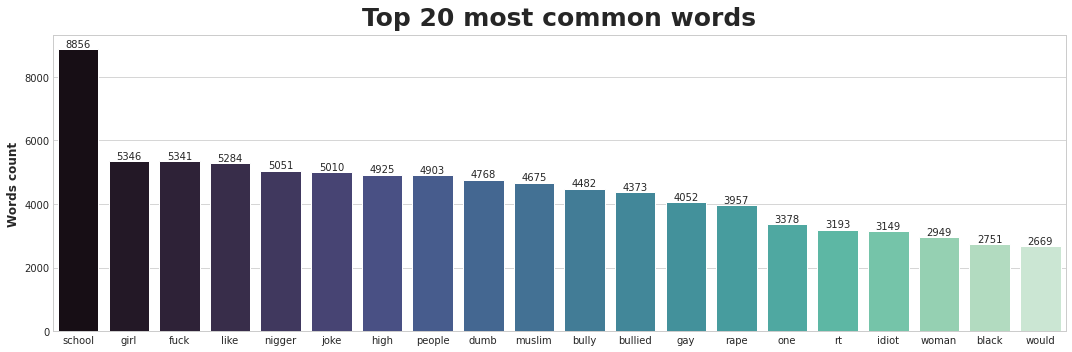

In [49]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(keys, values, palette='mako')
plt.title('Top 20 most common words', size=25)
ax.bar_label(ax.containers[0])
plt.ylabel("Words count")
plt.show()

# Word Embedding by Word2Vec

Next, we will create a word embedding matrix using the original text tweets and the pre trained model Word2vec.<br>
First, we create a list of words from the X_train vector created before.

In [50]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

We set a dimension of the embedding words, which can be seen as the number of featurs of each transformed word.

In [51]:
EMBEDDING_DIM = 200

Then we can instaniate the Word2Vec model by passing the training words and chosen embedding dimension to the imported Word2vec object.

In [52]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

Before defining the embedding matrix, we also need to choose the max number of words. We will extract the number of words from the vocabulary python dictionary we created before.

In [53]:
print(f"Vocabulary size: {len(vocabulary) + 1}")

Vocabulary size: 37570


In [54]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

Finally we can define the embedding matrix.

In [55]:
# Define an empty embedding matrix of shape (VOCAB_SIZE, EMBEDDING_DIM)
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Fill the embedding matrix with pre-trained values from word2vec
for word, token in vocabulary:
    # Check if the word is present in the word2vec model's vocabulary
    if word in word2vec_model.wv.key_to_index:
        # If the word is present, retrieve its embedding vector and add it to the embedding matrix
        embedding_vector = word2vec_model.wv[word]
        embedding_matrix[token] = embedding_vector

# Print the shape of the embedding matrix
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (37570, 200)


## Train - Validation - Test split

Now we will use the tokenized sentences to create a training, validation and test datasets.

In [56]:
X = tokenized_column
y = df['sentiment'].values

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [58]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

We can check the balance of the target classes:

In [59]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5015],
       [   1, 4965],
       [   2, 4701],
       [   3, 4626],
       [   4, 3886]])

And then apply random oversampling on the training set.

In [60]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train));

In [61]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5015],
       [   1, 5015],
       [   2, 5015],
       [   3, 5015],
       [   4, 5015]])

## PyTorch datasets and dataloaders

The three sets will be transformed to tensor datasets and dataloaders so we can extract the data in batches for the LSTM training, validation and testing.

In [62]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [63]:
BATCH_SIZE = 32

In [64]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

# PyTorch LSTM modeling with Attention Layer

In [65]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, is_bidirectional):
        super(Attention, self).__init__()
        self.is_bidirectional = is_bidirectional
        # The attention linear layer which transforms the input data to the hidden space
        self.attn = nn.Linear(hidden_dim * (4 if is_bidirectional else 2), hidden_dim * (2 if is_bidirectional else 1))
        # The linear layer that calculates the attention scores
        self.v = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        # Concatenate the last two hidden states in case of a bidirectional LSTM
        if self.is_bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=-1)
        else:
            hidden = hidden[-1]
        # Repeat the hidden state across the sequence length
        hidden_repeated = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        # Calculate attention weights
        attn_weights = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), dim=2)))
        # Compute attention scores
        attn_weights = self.v(attn_weights).squeeze(2)
        # Apply softmax to get valid probabilities
        return nn.functional.softmax(attn_weights, dim=1)


class LSTM_Sentiment_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, dropout, is_bidirectional):
        super(LSTM_Sentiment_Classifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers
        self.is_bidirectional = is_bidirectional

        # The Embedding layer that converts input words to embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer which processes the embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True, bidirectional=is_bidirectional)
        # Attention layer to compute the context vector
        self.attention = Attention(hidden_dim, is_bidirectional)
        # Fully connected layer which classifies the context vector into classes
        self.fc = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), num_classes)
        # Apply LogSoftmax to outputs for numerical stability
        self.softmax = nn.LogSoftmax(dim=1)
        # Dropout layer for regularisation
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        # Transform words to embeddings
        embedded = self.embedding(x)
        # Pass embeddings to LSTM
        out, hidden = self.lstm(embedded, hidden)
        # Calculate attention weights
        attn_weights = self.attention(hidden[0], out)
        # Calculate context vector by taking the weighted sum of LSTM outputs
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        # Classify the context vector
        out = self.softmax(self.fc(context))
        return out, hidden

    def init_hidden(self, batch_size):
        # Factor determines the size of hidden states depending on bidirectionality
        factor = 2 if self.is_bidirectional else 1
        # Initial hidden and cell states are zero
        h0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        c0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        hidden

In [66]:
NUM_CLASSES = 5 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

IS_BIDIRECTIONAL = False # Set this to False for unidirectional LSTM, and True for bidirectional LSTM

LR = 4e-4 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
EPOCHS = 10 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, DROPOUT, IS_BIDIRECTIONAL)

model = model.to(DEVICE)

# Initialize the embedding layer with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
# Allow the embedding matrix to be fine-tuned to better adapt to our dataset and get higher accuracy
model.embedding.weight.requires_grad = True

# Set up the criterion (loss function)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

print(model)

LSTM_Sentiment_Classifier(
  (embedding): Embedding(37570, 200)
  (lstm): LSTM(200, 100, batch_first=True)
  (attention): Attention(
    (attn): Linear(in_features=200, out_features=100, bias=True)
    (v): Linear(in_features=100, out_features=1, bias=False)
  )
  (fc): Linear(in_features=100, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)


# LSTM Training loop 

Now we will define a custom training loop, where we include an early stopping functionality, and save only the best models in terms of validation accuracy.

In [67]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients 

        output, h = model(inputs,h) #get output and hidden states from LSTM network
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list
        
        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 92.058011).  Saving model ...
	Train_loss : 0.6215 Val_loss : 0.2344
	Train_acc : 75.806% Val_acc : 92.058%
Epoch 2:Validation accuracy increased (92.058011 --> 92.800414).  Saving model ...
	Train_loss : 0.1746 Val_loss : 0.2172
	Train_acc : 94.265% Val_acc : 92.800%
Epoch 3:Validation accuracy increased (92.800414 --> 93.111188).  Saving model ...
	Train_loss : 0.1030 Val_loss : 0.2198
	Train_acc : 96.715% Val_acc : 93.111%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.0608 Val_loss : 0.2779
	Train_acc : 98.092% Val_acc : 91.730%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.0386 Val_loss : 0.2917
	Train_acc : 98.867% Val_acc : 91.747%
Epoch 6:Validation accuracy did not increase
	Train_loss : 0.0272 Val_loss : 0.3287
	Train_acc : 99.238% Val_acc : 91.333%
Epoch 7:Validation accuracy did not increase
	Train_loss : 0.0201 Val_loss : 0.3336
	Train_acc : 99.433% Val_acc : 91.367%
Epoch 8:Validation accurac

In [68]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

# LSTM Testing

In [69]:
def evaluate_model(model, test_loader):
    model.eval()
    y_pred_list = []
    y_test_list = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            test_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, test_h)
            y_pred_test = torch.argmax(output, dim=1)
            y_pred_list.extend(y_pred_test.squeeze().tolist())
            y_test_list.extend(labels.squeeze().tolist())
    
    return y_pred_list, y_test_list

y_pred_list, y_test_list = evaluate_model(model, test_loader)

In [70]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=sentiments))

Classification Report for Bi-LSTM :
               precision    recall  f1-score   support

    religion       0.95      0.96      0.96      1568
         age       0.98      0.98      0.98      1548
   ethnicity       0.98      0.98      0.98      1461
      gender       0.93      0.85      0.89      1443
not bullying       0.79      0.86      0.82      1212

    accuracy                           0.93      7232
   macro avg       0.93      0.93      0.92      7232
weighted avg       0.93      0.93      0.93      7232



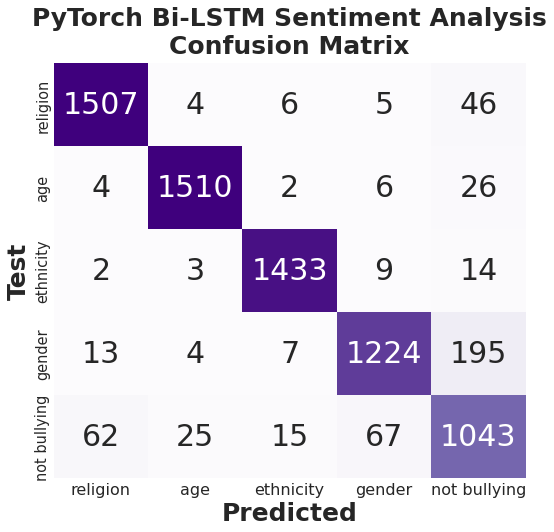

In [71]:
conf_matrix(y_test_list,y_pred_list,'PyTorch Bi-LSTM Sentiment Analysis\nConfusion Matrix', sentiments)

**The performance scores of the algorithm are very high, with an overall accuracy of 93%.**<br>
**In particular, the F1 scores for the more populated classes are over 95%**